In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/qa-intents-dataset-university-domain/dataset_test.tsv
/kaggle/input/qa-intents-dataset-university-domain/labels_description.txt
/kaggle/input/qa-intents-dataset-university-domain/dataset_train.tsv


In [2]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset 
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score

In [5]:
train_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_train.tsv',delimiter='\t',encoding="utf-8",names=['text', 'intent'])
test_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_test.tsv',delimiter='\t',encoding="utf-8",names=['text', 'intent'])
train_data.head()

,text,intent
0,мне нужна справка,statement_general
1,оформить справку,statement_general
2,взять справку,statement_general
3,справку как получить,statement_general
4,справку ммф где получаться,statement_general


In [6]:
full_data = pd.concat([train_data, test_data])
full_data.head()

,text,intent
0,мне нужна справка,statement_general
1,оформить справку,statement_general
2,взять справку,statement_general
3,справку как получить,statement_general
4,справку ммф где получаться,statement_general


In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(full_data, test_size=0.2, random_state=42)
unique_values_normalized = train['intent'].value_counts(normalize=True)
print(unique_values_normalized*100)

intent
sched_teacher                8.582817
sched_for_group              3.126661
sched_for_group_day          3.046944
wifi                         2.143490
status_free                  2.037201
                               ...   
location_general             0.168291
loc_nsu_cafeteria            0.168291
student_trade_union_enter    0.159433
loc_passport_office          0.159433
staff_trade_union_enter      0.159433
Name: proportion, Length: 142, dtype: float64


In [8]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [9]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Добавление дополнительного измерения
#         print(f'x shape: {x.shape}')
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [10]:
# !
from sklearn.preprocessing import LabelEncoder

# Создание LabelEncoder
le = LabelEncoder()

# Подготовка данных
full_data = pd.concat([train_data, test_data])
train, test = train_test_split(full_data, test_size=0.2, random_state=42)

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])

# # Токенизация и преобразование в TF-IDF
# tokenizer = word_tokenize
# vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words='english')

# train_texts = vectorizer.fit_transform(train['text']).toarray()
# test_texts = vectorizer.transform(test['text']).toarray()

# # Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
# train_dataset = TextDataset(torch.from_numpy(train_texts), train_labels)
# test_dataset = TextDataset(torch.from_numpy(test_texts), test_labels)


In [11]:
# Токенизация и преобразование в TF-IDF
tokenizer = word_tokenize
vectorizer = TfidfVectorizer(tokenizer=tokenizer)

train_texts = vectorizer.fit_transform(train['text']).toarray()
test_texts = vectorizer.transform(test['text']).toarray()

# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(torch.from_numpy(train_texts), train_labels)
test_dataset = TextDataset(torch.from_numpy(test_texts), test_labels)


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
# Подготовка данных
# full_data = pd.concat([train_data, test_data])
# train, test = train_test_split(full_data, test_size=0.2, random_state=42)

# le = LabelEncoder()
# train_labels = le.fit_transform(train['intent'])
# test_labels = le.transform(test['intent'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


100%|██████████| 89/89 [00:00<00:00, 156.77it/s]


Epoch 1, Train Loss: 3.762012464466581, Val Loss: 1.9905650649177895


100%|██████████| 89/89 [00:00<00:00, 166.49it/s]


Epoch 2, Train Loss: 0.9644932008583215, Val Loss: 0.42200039980116855


100%|██████████| 89/89 [00:00<00:00, 161.98it/s]


Epoch 3, Train Loss: 0.26498753523649304, Val Loss: 0.19421887950281078


100%|██████████| 89/89 [00:00<00:00, 163.37it/s]


Epoch 4, Train Loss: 0.14985606370878962, Val Loss: 0.1476608639101634


100%|██████████| 89/89 [00:00<00:00, 164.53it/s]


Epoch 5, Train Loss: 0.11706688297548393, Val Loss: 0.1318985675199983


100%|██████████| 89/89 [00:00<00:00, 157.10it/s]


Epoch 6, Train Loss: 0.10332280550964662, Val Loss: 0.12595792298906305


100%|██████████| 89/89 [00:00<00:00, 160.79it/s]


Epoch 7, Train Loss: 0.0967298823688443, Val Loss: 0.1225703859785467


100%|██████████| 89/89 [00:00<00:00, 158.10it/s]


Epoch 8, Train Loss: 0.09307793947200557, Val Loss: 0.1210257487863386


100%|██████████| 89/89 [00:00<00:00, 165.74it/s]


Epoch 9, Train Loss: 0.09051145838010297, Val Loss: 0.12074560930512929


100%|██████████| 89/89 [00:00<00:00, 162.50it/s]


Epoch 10, Train Loss: 0.08897625488458628, Val Loss: 0.1201369918364864


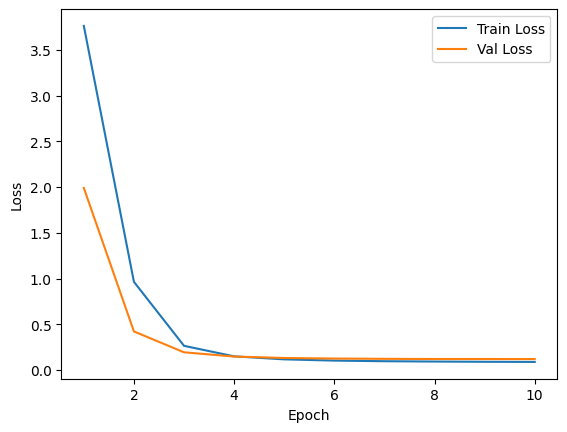

In [13]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Создание и обучение модели
model = LSTMClassifier(input_dim=train_texts.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

for epoch in range(10):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for i, (texts, labels) in enumerate(tqdm(train_loader)):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for i, (texts, labels) in enumerate(tqdm(test_loader)):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Построение графика потерь
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
# Прогнозирование на тестовом наборе
predictions = []
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

print(balanced_accuracy_score(test_labels, predictions))
print(precision_recall_fscore_support(test_labels, predictions, average = 'weighted'))

0.9527577155454766
(0.9499178368191363, 0.9518243003896564, 0.9496336133947143, None)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
